In [2]:
import socket
import json
import ast
from datetime import datetime
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
#from fipa_acl import create_fipa_acl_message, parse_fipa_acl_message
from sklearn import metrics
import threading



In [3]:
df = pd.read_csv(r'.\FVTrain.csv', parse_dates=['Date'])
df = df.dropna()
#target = df['Power']
# --------------------- 1. Estructura de los datos --------------------- #
df = df.dropna()

In [4]:

#check if the 'Date' column is in datetime format
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Date'] = pd.to_datetime(df['Date'])

#check null values
if df.isnull().values.any():
    print("Data contains null values. Please clean the data before proceeding.")   


C:\Users\Usuario\AppData\Local\Temp\ipykernel_8076\2658432322.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


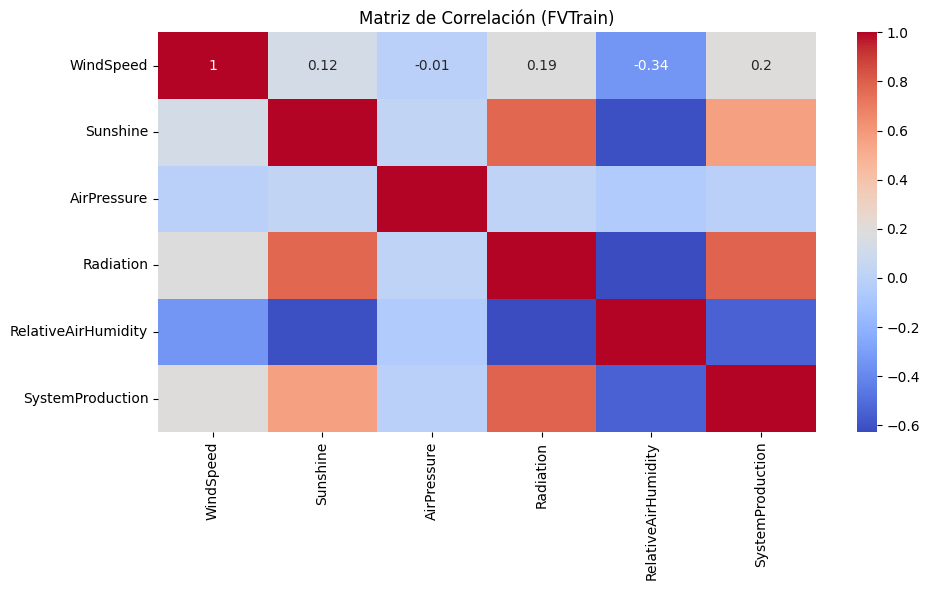

                   Feature        VIF
0            VIF_WindSpeed   4.106952
1             VIF_Sunshine   3.476851
2          VIF_AirPressure  44.621707
3            VIF_Radiation   3.548288
4  VIF_RelativeAirHumidity  31.233831


In [5]:

# Correlation heat‑map
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación (FVTrain)')
plt.tight_layout()
plt.show()
plt.savefig('correlation_matrix.png')
plt.close()

# Chequeamos si existe multicolinealidad
X_full = df.drop(columns=['Date', 'SystemProduction'])  # all candidate predictors except target variable
# VIF (Variance Inflation Factor)
vif = pd.DataFrame()
vif['Feature'] = X_full.columns
vif['VIF'] = [variance_inflation_factor(X_full.values, i) for i in range(X_full.shape[1])]
# Añadir el nombre de la columna a los valores de VIF
vif['Feature'] = vif['Feature'].apply(lambda x: f"VIF_{x}")
# Mostrar el DataFrame de VIF
print(vif)


In [6]:

#Start to drop the variables with high VIF, we start with the  highest one: VIF_windspeed_10m
# The criteria usually used is VIF <= 10
cols_to_drop = ['AirPressure']
X_reduced = X_full.drop(columns=cols_to_drop)
# Check the VIF again
vif_reduced = pd.DataFrame()
vif_reduced['Feature'] = X_reduced.columns
vif_reduced['VIF'] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]
print(vif_reduced)


               Feature       VIF
0            WindSpeed  3.077586
1             Sunshine  3.163079
2            Radiation  3.329874
3  RelativeAirHumidity  2.610142


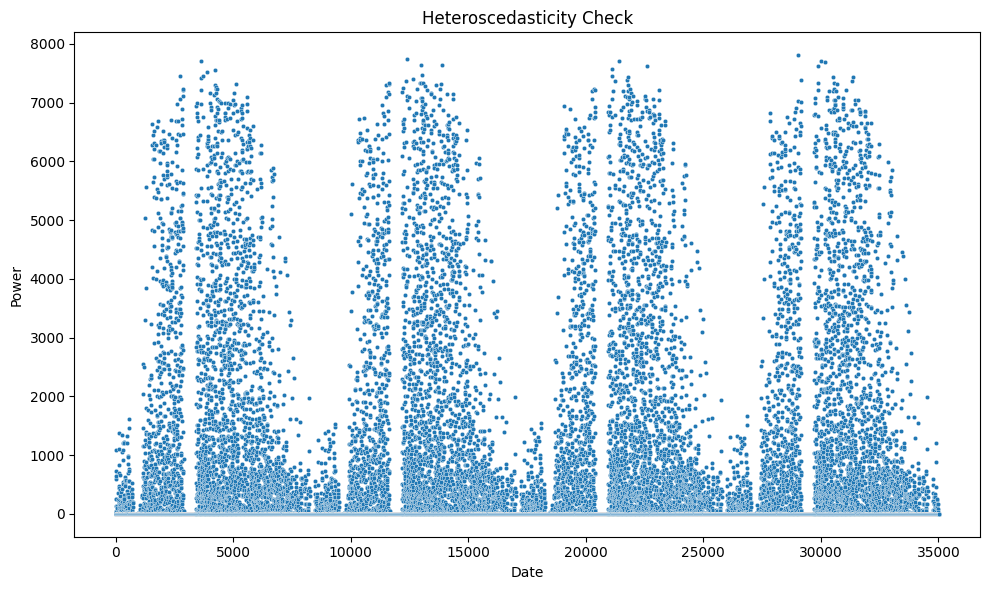

White's LM statistic : 34497.16
White's test p-value : 0.0000
White's F statistic  : 116339.78
White's F p-value    : 0.0000


In [7]:

#guarda el df las variables seleccionadas
selected_features = list(X_full.columns)
# Guardar en un dataframe las variables seleccionadas
df_selected = pd.DataFrame(selected_features, columns=['Selected Features'])

#usa de df las variables seleccionadas, Power y Date
df = df[['Date', 'SystemProduction'] + selected_features]

#Check heteroscedasticity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y=df['SystemProduction'], s=10)
plt.title('Heteroscedasticity Check')
plt.xlabel('Date')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

# White's test for heteroscedasticity
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

# 1Build the design matrix with an intercept
X   = sm.add_constant(df[selected_features])   # adds the constant as the first column
y   = df['Radiation']

# Fit the OLS model and obtain residuals
ols_results = sm.OLS(y, X).fit()
resid       = ols_results.resid

# Run White’s test
#     exog must be exactly the same matrix (including the constant) that you used in the regression
white_test = het_white(resid, X)

lm_stat, p_value, f_stat, f_p_value = white_test
print(f"White's LM statistic : {lm_stat:.2f}")
print(f"White's test p-value : {p_value:.4f}")
print(f"White's F statistic  : {f_stat:.2f}")
print(f"White's F p-value    : {f_p_value:.4f}")


Lasso Regression - RMSE: 941.14, R²: 0.613
Ridge Regression - RMSE: 941.14, R²: 0.613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 28012, number of used features: 5
[LightGBM] [Info] Start training from score 680.582889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Regression - RMSE: 740.67, R²: 0.760


<Figure size 1200x600 with 0 Axes>

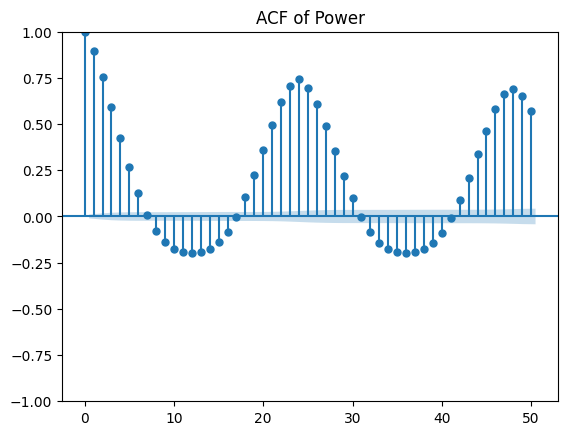

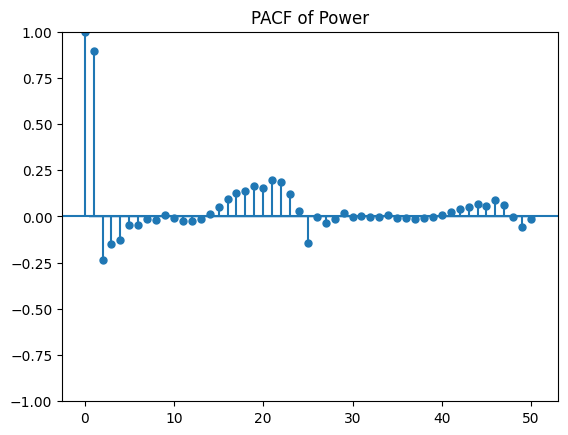

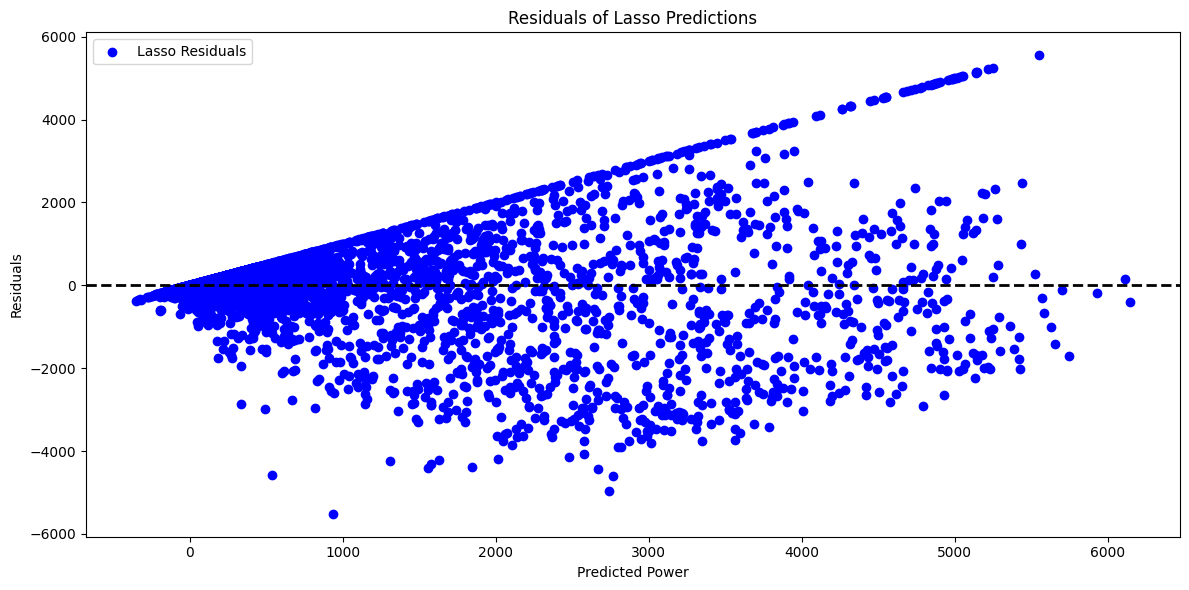

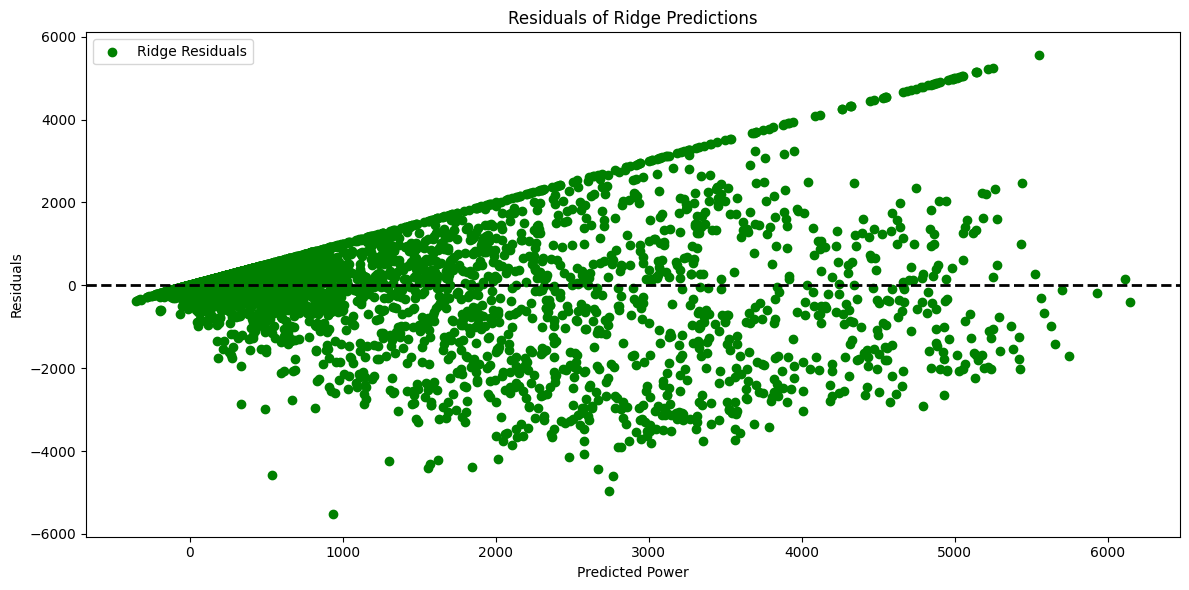

In [8]:

#Time Series Analysis

# plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))
plot_acf(df['SystemProduction'], lags=50, title='ACF of Power')
plot_pacf(df['SystemProduction'], lags=50, title='PACF of Power')
plt.savefig('acf_pacf_power.png')


# Modelos de predicción
# Dividimos el dataset en train y test
# divide un train and validadion set
#x_train y y_train es el train set
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV, RidgeCV

# Split the data into features and target variable
X_full = df[selected_features]
y = df['SystemProduction']  # target variable

X_train, X_val, y_train, y_val = train_test_split(X_full, y, test_size=0.2, random_state=42)
# Lasso Regression
from sklearn.linear_model import LassoCV, RidgeCV
lasso_model = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=42)
lasso_model.fit(X_train, y_train)
# Evaluate Lasso
lasso_val_pred = lasso_model.predict(X_val)
lasso_rmse = np.sqrt(mean_squared_error(y_val, lasso_val_pred))
lasso_r2 = r2_score(y_val, lasso_val_pred)
print(f"Lasso Regression - RMSE: {lasso_rmse:.2f}, R²: {lasso_r2:.3f}")
# Ridge Regression
ridge_model = RidgeCV(alphas=np.logspace(-4, 4, 100), cv=5)
ridge_model.fit(X_train, y_train)
# Evaluate Ridge
ridge_val_pred = ridge_model.predict(X_val)
ridge_rmse = np.sqrt(mean_squared_error(y_val, ridge_val_pred))
ridge_r2 = r2_score(y_val, ridge_val_pred)
print(f"Ridge Regression - RMSE: {ridge_rmse:.2f}, R²: {ridge_r2:.3f}")
# LightGBM Regression
from lightgbm import LGBMRegressor
params = {
    "learning_rate": 0.2,
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "max_depth": 10,
}
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
# Evaluate LightGBM
lgbm_val_pred = lgbm_model.predict(X_val)
lgbm_rmse = np.sqrt(mean_squared_error(y_val, lgbm_val_pred))
lgbm_r2 = r2_score(y_val, lgbm_val_pred)
print(f"LightGBM Regression - RMSE: {lgbm_rmse:.2f}, R²: {lgbm_r2:.3f}")
# Plot residuals for Lasso
plt.figure(figsize=(12, 6))
plt.scatter(lasso_val_pred, lasso_val_pred - y_val, c='blue', marker='o', label='Lasso Residuals')
plt.xlabel('Predicted Power')
plt.ylabel('Residuals')
plt.title('Residuals of Lasso Predictions')
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.legend()
plt.tight_layout()
plt.show()

# Plot residuals for Ridge
plt.figure(figsize=(12, 6))
plt.scatter(ridge_val_pred, ridge_val_pred - y_val, c='green', marker='o', label='Ridge Residuals')
plt.xlabel('Predicted Power')
plt.ylabel('Residuals')
plt.title('Residuals of Ridge Predictions')
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.legend()
plt.tight_layout()
plt.show()


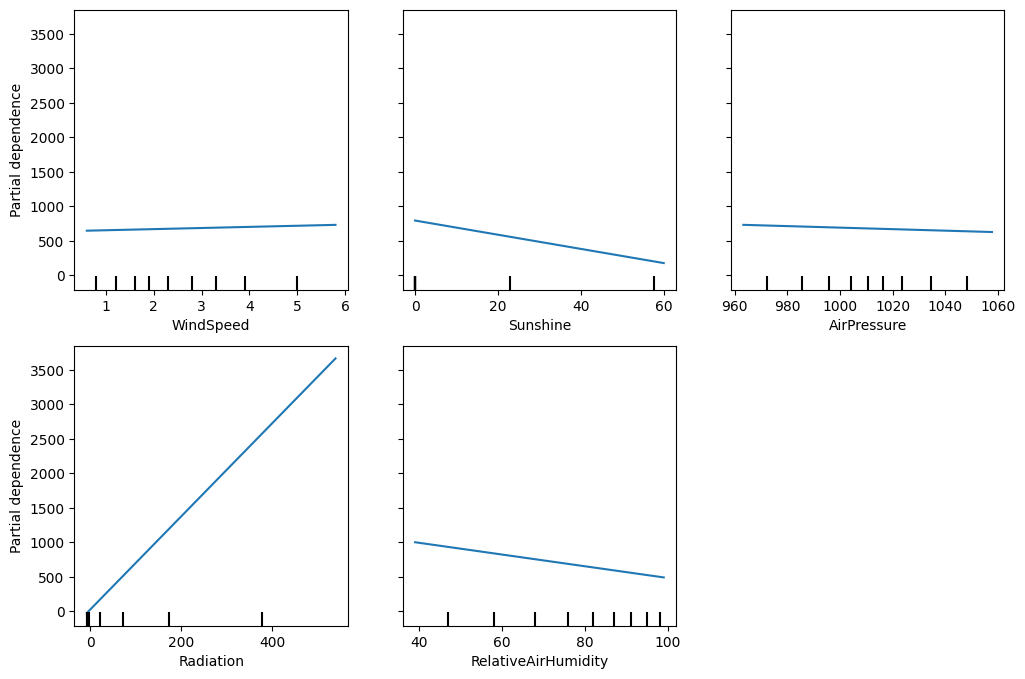

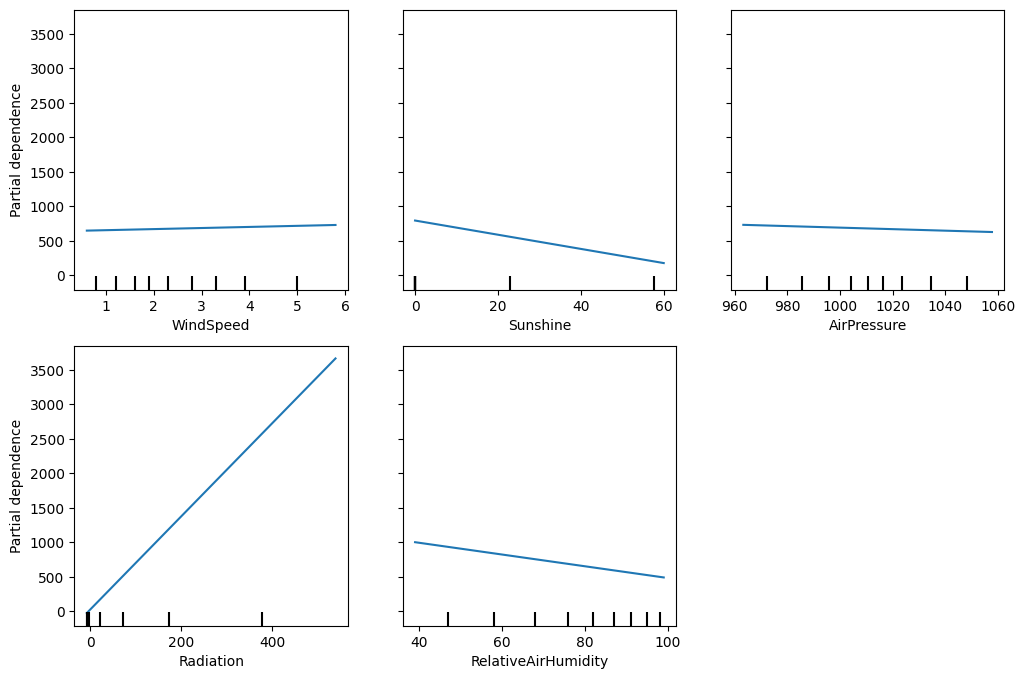

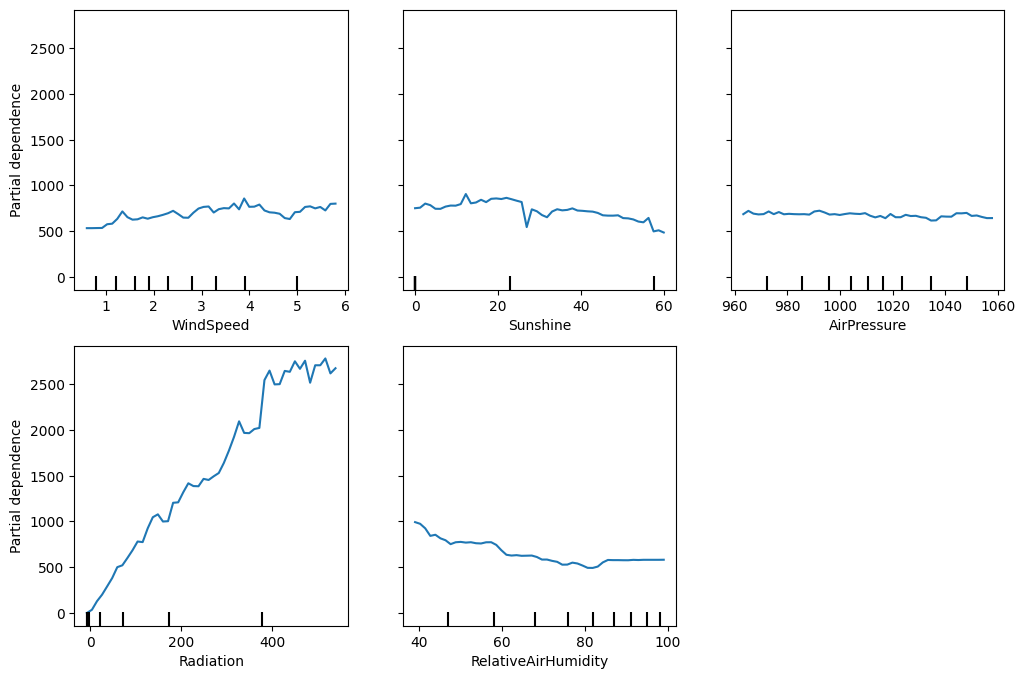

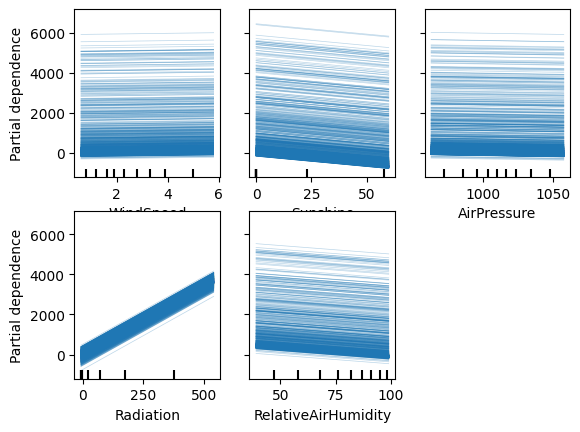

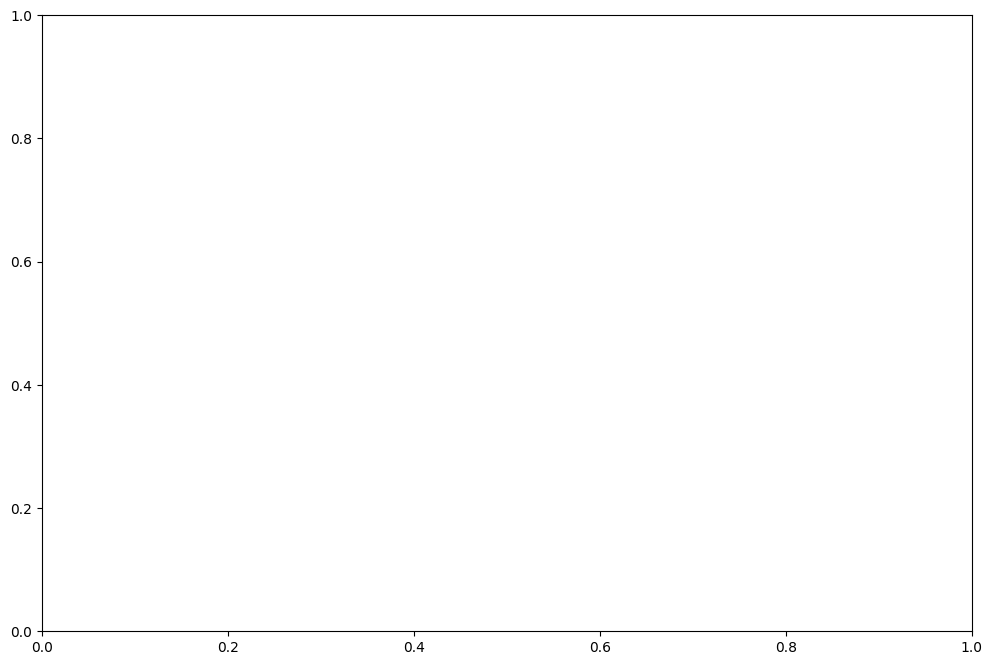

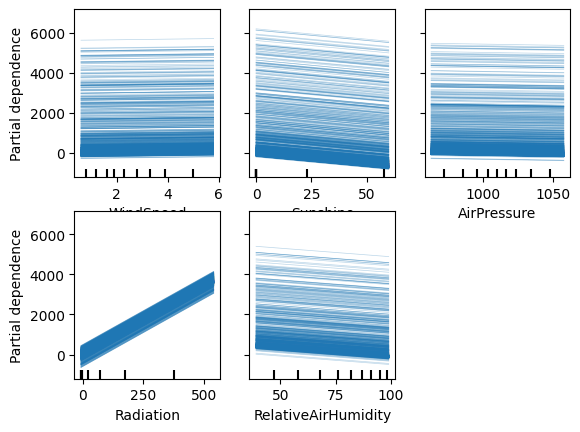

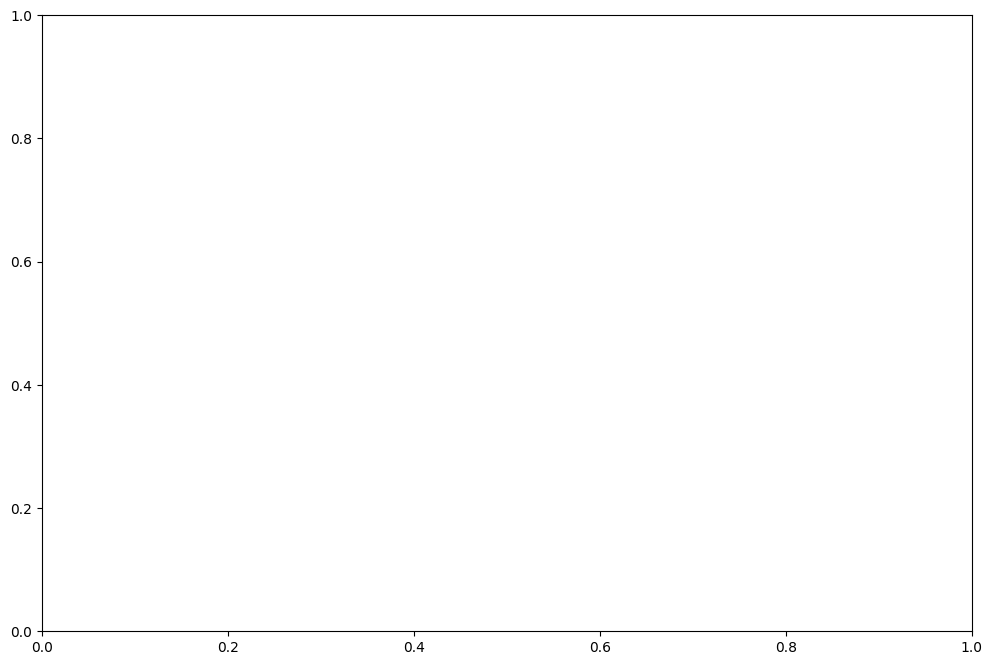

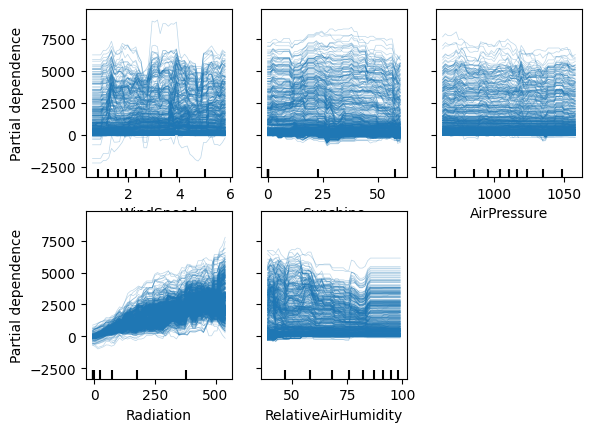

In [9]:
# ---- xAI ----# Empezamos por la explicabilidad de los modelos Ridge y Lasso
# Modelos Globales: PDP (Partial Dependence Plots), ADP (Accumulated Dependence Plots) y ICE (Individual Conditional Expectation)
# Plot Partial Dependence for Lasso
from sklearn.inspection import PartialDependenceDisplay
# Plot Partial Dependence for Lasso
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lasso_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# Plot partial dependence for Ridge
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    ridge_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# Plot partial dependence for LightGBM
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lgbm_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# ICE (Individual Conditional Expectation) plots for Lasso
PartialDependenceDisplay.from_estimator(
    lasso_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)
# Plot ICE for Ridge
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    ridge_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)
# Plot ICE for LightGBM
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lgbm_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)


c:\Users\Usuario\Documents\Mondragon_AI_Applied_Masters_Degree\Reto4\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\Usuario\Documents\Mondragon_AI_Applied_Masters_Degree\Reto4\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warning

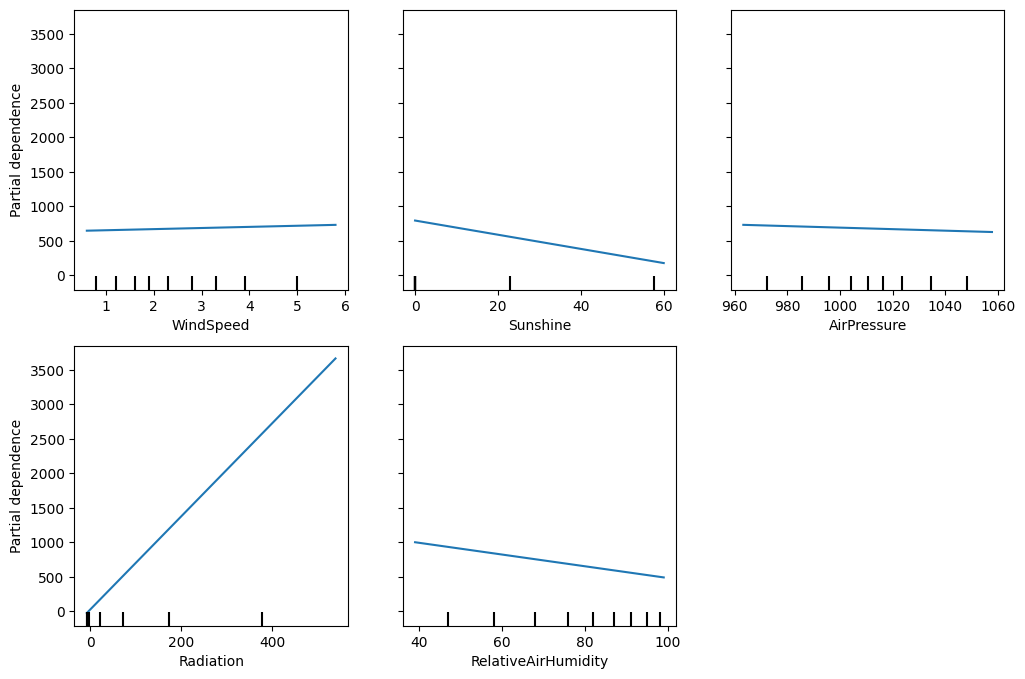

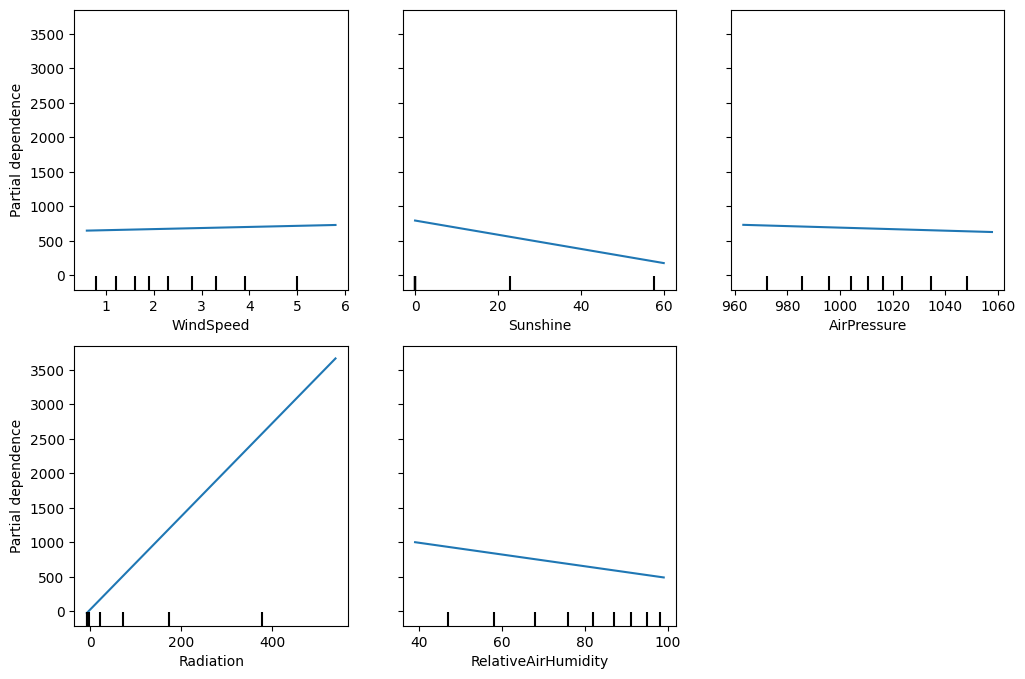

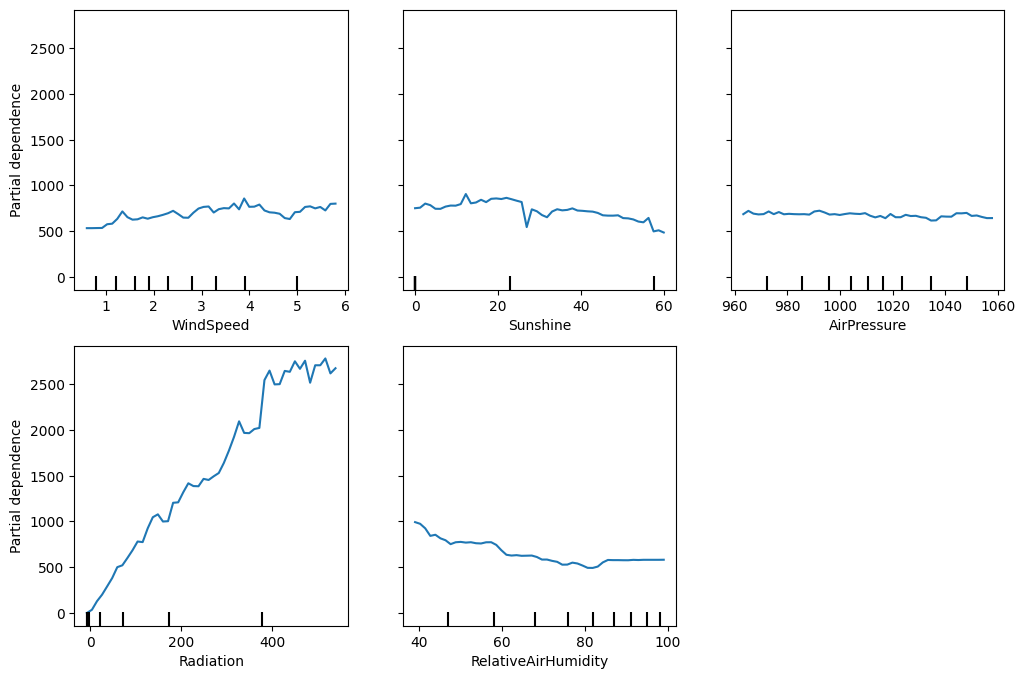

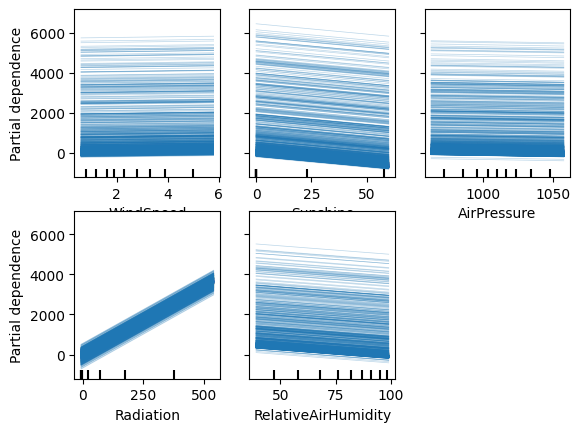

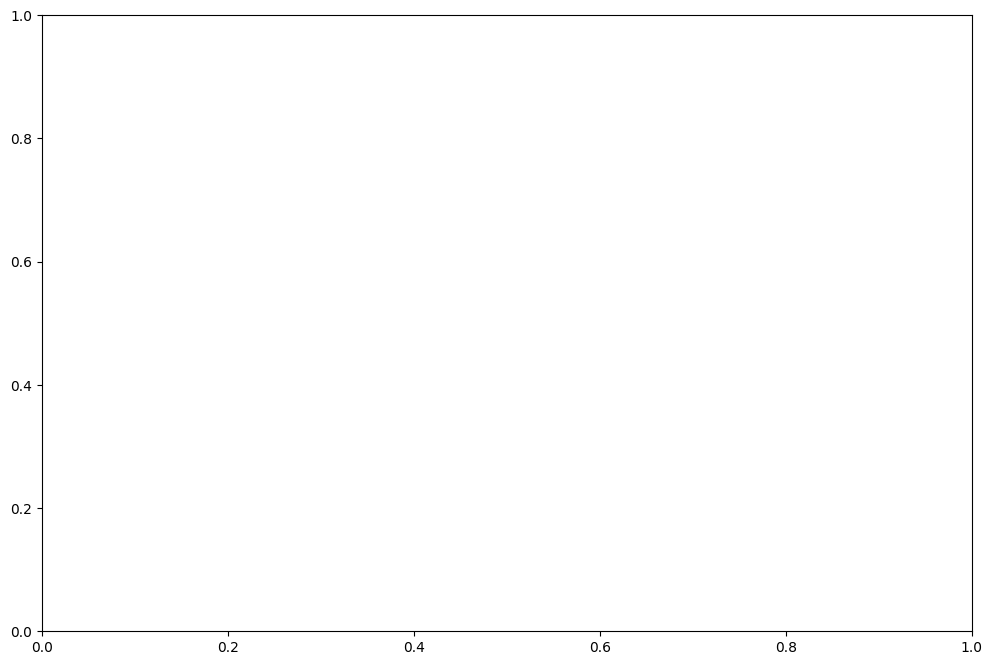

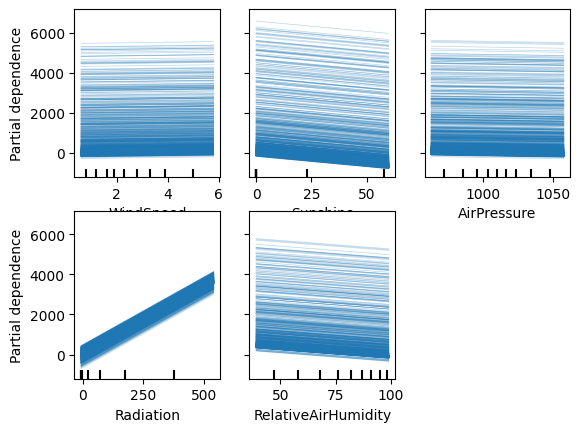

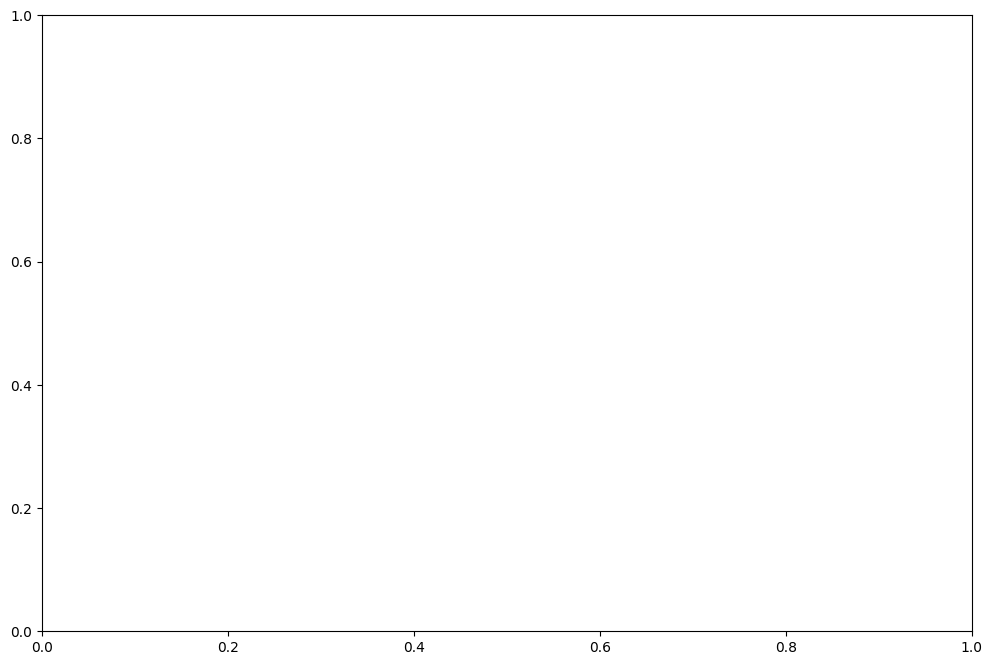

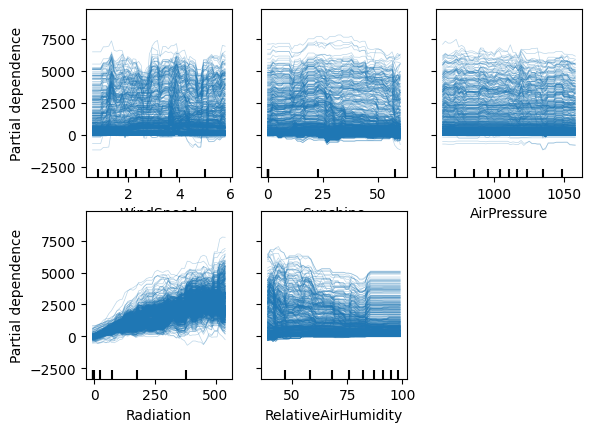

In [11]:

#----xAI----

#Empezamos por la explicabilidad de los modelos Ridge y Lasso
# Modelos Globales: PDP (Partial Dependence Plots), ADP (Accumulated Dependence Plots) y ICE (Individual Conditional Expectation)
# Plot Partial Dependence for Lasso
from sklearn.inspection import PartialDependenceDisplay
# Plot Partial Dependence for Lasso
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lasso_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# Plot partial dependence for Ridge
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    ridge_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# Plot partial dependence for LightGBM
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lgbm_model,
    X_train,
    features=selected_features,
    ax=ax,
    grid_resolution=50
)
# ICE (Individual Conditional Expectation) plots for Lasso
PartialDependenceDisplay.from_estimator(
    lasso_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)
# Plot ICE for Ridge
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    ridge_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)
# Plot ICE for LightGBM
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    lgbm_model,
    X_train,
    features=selected_features,
    grid_resolution=50,
    kind='individual'
)


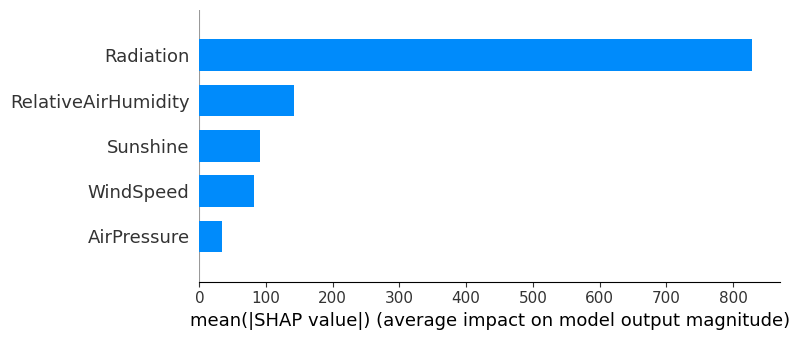

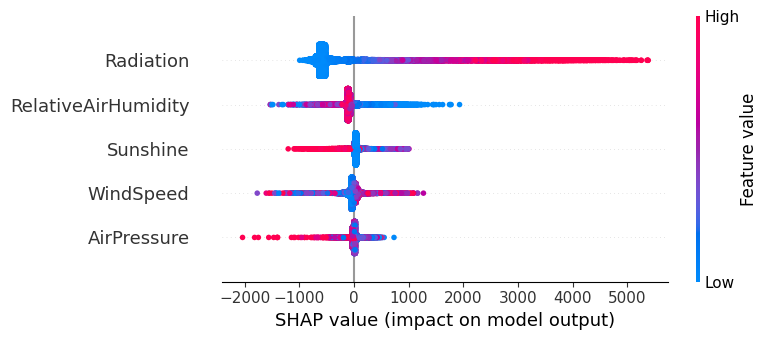

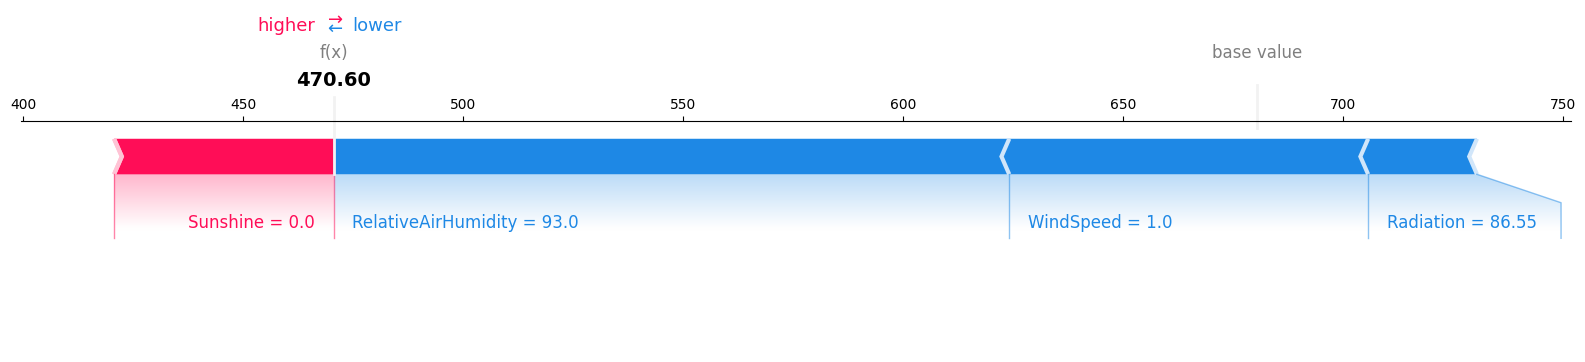

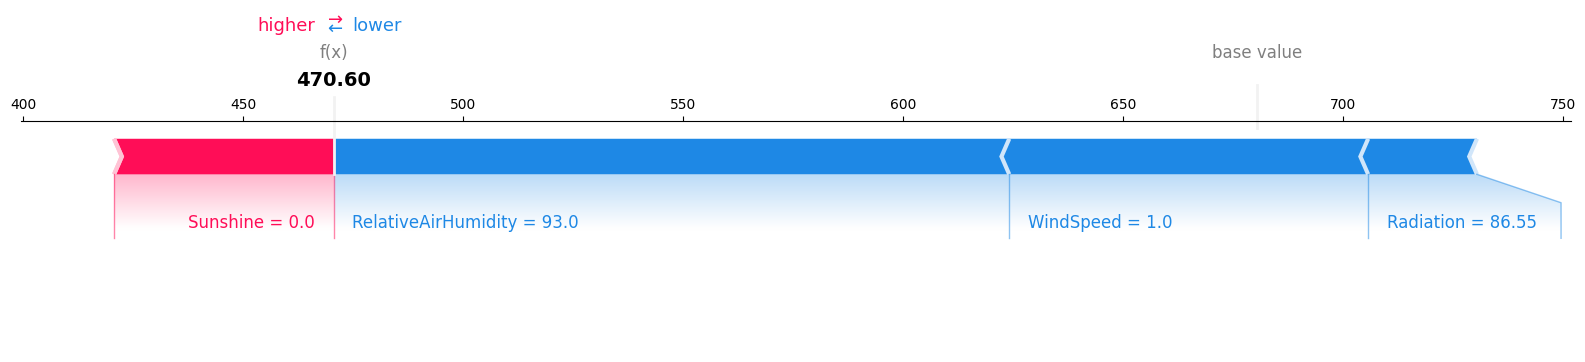

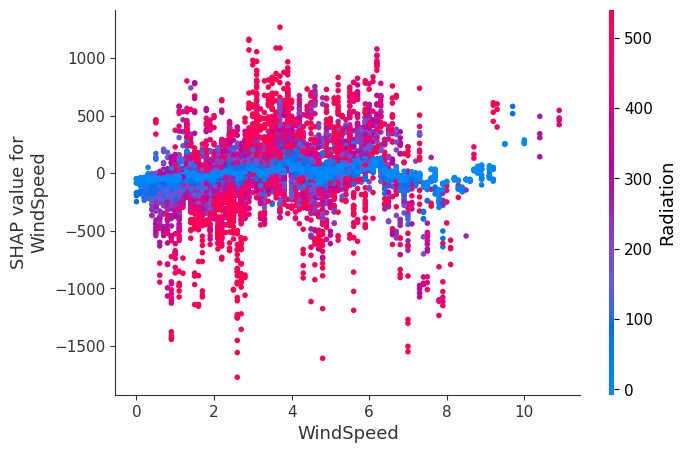

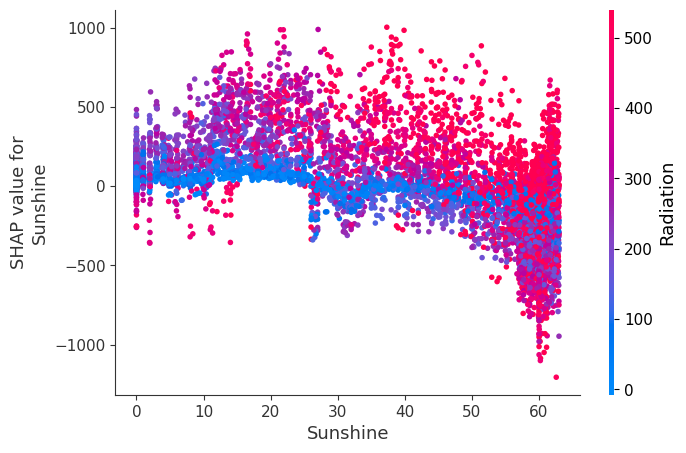

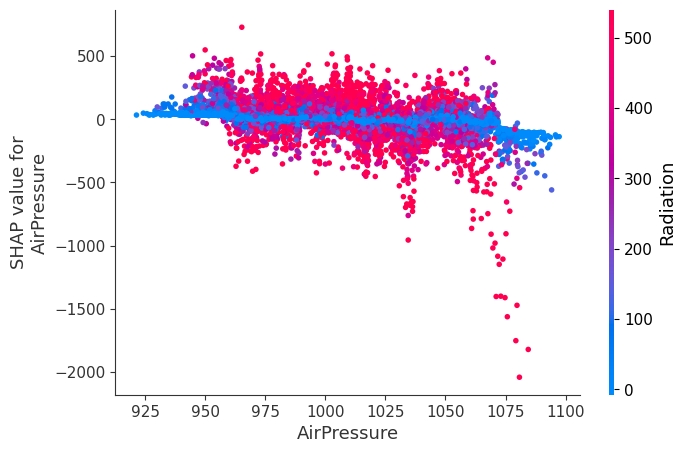

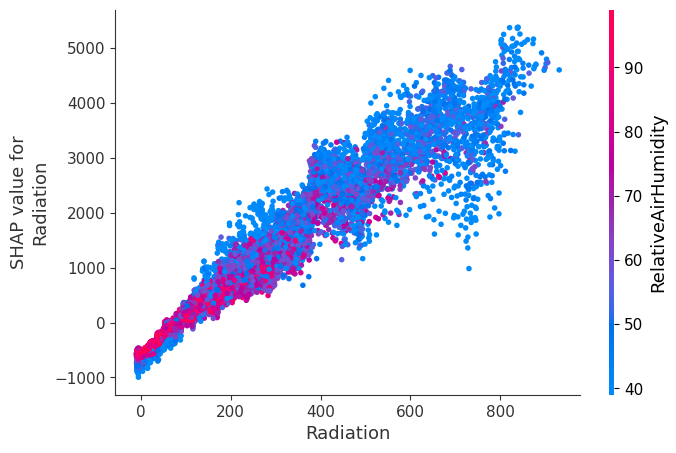

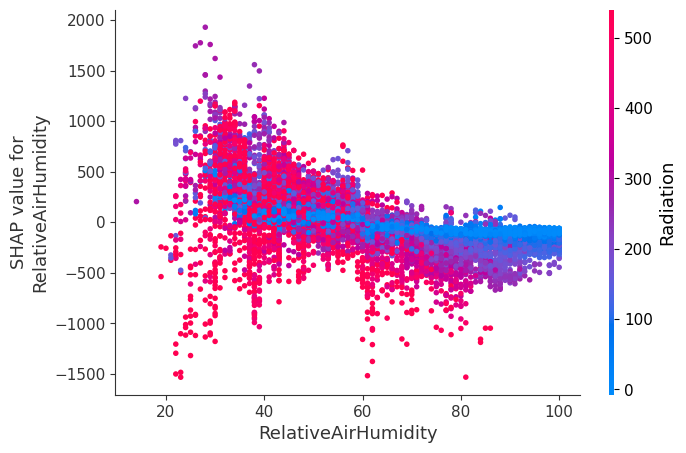

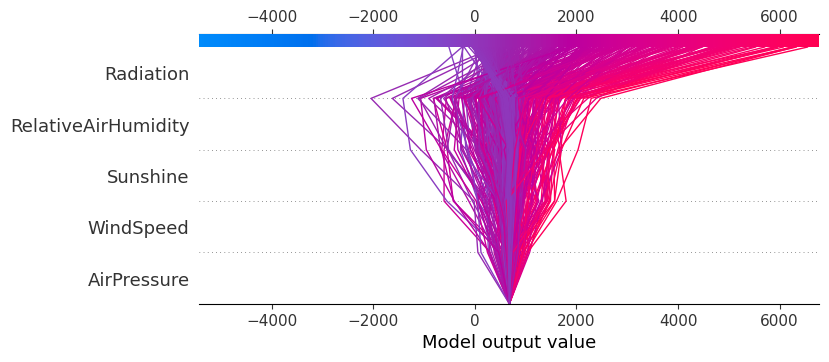

In [10]:

# ------ Local Explanations with SHAP, LIME and Ceteris Paribus ------
# Agnostic models: SHAP (SHapley Additive exPlanations)
import shap
shap.initjs()

# 1 Create explainer
explainer    = shap.TreeExplainer(lgbm_model)

# 2 Compute SHAP values once
shap_values  = explainer.shap_values(X_train)

# ── Global views ──────────────────────────────────────────
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

# ── Local force plot ──────────────────────────────────────
row = 0                       # choose the row you want to explain
if isinstance(shap_values, list):          # multi-class
    class_id     = 2                      # pick the class to display
    base_value   = explainer.expected_value[class_id]
    row_shap     = shap_values[class_id][row, :]
else:                                      # regression or single-output
    base_value   = explainer.expected_value
    row_shap     = shap_values[row, :]

shap.force_plot(
    base_value,            # ← NEW first argument in v0.20+
    row_shap,              # SHAP vector for the chosen instance
    X_train.iloc[row, :],  # feature values for that instance
    matplotlib=True        # set False for the interactive JS view
)

shap.force_plot(
    base_value,            # ← NEW first argument in v0.20+
    row_shap,              # SHAP vector for the chosen instance
    X_train.iloc[row, :],  # feature values for that instance
    matplotlib=True        # set False for the interactive JS view
)


# Plot SHAP values for specific features, haz un bucle de las variables seleccionadas
# ── dependence plots for the features you picked ───
for feature in selected_features:
    # single-output regression / binary classification
    shap.dependence_plot(feature,
                         shap_values,         # ← NOT explainer
                         X_train)

# ── dependence plots for the features you picked ───
import numpy as np
n_show   = 1000
idx      = np.random.choice(X_train.shape[0], n_show, replace=False)

shap.decision_plot(
    base_value,
    shap_values[idx],
    X_train.iloc[idx],
    link='identity'
)

# ── choose how many rows you want to display in the force plot ──
n_show = 1_000           # or any smaller number that renders quickly

# single-output regression / binary classification
if isinstance(shap_values, np.ndarray):
    shap.force_plot(
        explainer.expected_value,     # base value
        shap_values[:n_show, :],      # NO “.values” here
        X_train.iloc[:n_show, :],
        matplotlib=False              # interactive JS view (omit for Jupyter)
    )

# multi-class example → pick one class to visualise
else:                                 # shap_values is a list
    class_id = 0                      # the class you want to show
    shap.force_plot(
        explainer.expected_value[class_id],
        shap_values[class_id][:n_show, :],
        X_train.iloc[:n_show, :],
        matplotlib=False
    )
shap.force_plot(explainer.expected_value, shap_values[:n_show, :], X_train.iloc[:n_show, :], matplotlib=False)


In [13]:
# LIME (Local Interpretable Model‑agnostic Explanations)
from lime.lime_tabular import LimeTabularExplainer

explainer_lime = LimeTabularExplainer(
    training_data         = X_train.values,
    feature_names         = X_train.columns.tolist(),
    mode                  = 'regression',
    discretize_continuous = True
)

row_id = 2940
explanation = explainer_lime.explain_instance(
    data_row     = X_val.iloc[row_id].values,
    predict_fn   = lgbm_model.predict,
    num_features = X_train.shape[1]
)


#explanation.show_in_notebook(show_table=True, show_all=False)
display(HTML(explanation.as_html()))


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



NameError: name 'HTML' is not defined

In [14]:
import dalex as dx

# Create a DALEX explainer
explainer = dx.Explainer(
    model=lgbm_model,
    data=X_train,
    y=y_train,
    label="LightGBM Model - FV Module"
)

pfi = explainer.model_parts(loss_function='rmse')
pfi.plot(max_vars=25)

# Partial dependence plots (PDP) con dalex

###  (ya tienes `explainer` definido)  ###
vars_to_check = selected_features[:5]          # primeras 5 por claridad

pdp = explainer.model_profile(
        variables     = vars_to_check,
        type          = "partial",
        variable_type = "numerical")

pdp.plot(title="PDP – LightGBM – FV Module")


# otro explainer para el modelo de Ridge
ridge_exp = dx.Explainer(ridge_model, X_train, y_train, label="Ridge")
lasso_exp = dx.Explainer(lasso_model, X_train, y_train, label="Lasso")
# PDP de la misma(s) variable(s)
pdp_lgbm  = explainer.model_profile(
                variables     = vars_to_check,   # <─ lista de variables
                type          = "partial",       # PDP
                variable_type = "numerical"      # opcional
)

pdp_ridge = ridge_exp.model_profile(

                variables     = vars_to_check,
                type          = "partial",
                variable_type = "numerical"
)
pdp_lasso = lasso_exp.model_profile(

                variables     = vars_to_check,
                type          = "partial",
                variable_type = "numerical"
)

pdp_ridge.plot(title="PDP – Ridge – FV Module")
pdp_lasso.plot(title="PDP – Lasso – FV Module")

# Accumulated Local Effects (ALE) plots
# ── 2. Calcular los perfiles ALE ─────────────────────────────────
ale_lgbm = explainer.model_profile(
              variables     = None,        # lista o str
              type          = "accumulated",   # ← la clave
              variable_type = "numerical",     # o "categorical"
              span          = 0.25,            # suavizado (opc.)
              center        = True             # centra en ŷ media
)

# ── 3. Visualizar ────────────────────────────────────────────────
ale_lgbm.plot(title="Accumulated Local Effects – LightGBM")

# Para comparar con otro modelo:
ridge_exp  = dx.Explainer(ridge_model, X_train, y_train, label="Ridge")
ale_ridge  = ridge_exp.model_profile(variables=None, type="accumulated")
ale_lgbm.plot(ale_ridge)      # dos curvas en la misma figura




Preparation of a new explainer is initiated

  -> data              : 28012 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 28012 values
  -> model_class       : lightgbm.sklearn.LGBMRegressor (default)
  -> label             : LightGBM Model - FV Module
  -> predict function  : <function yhat_default at 0x000001CA6FFDCF40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -9.13e+02, mean = 6.81e+02, max = 7.72e+03
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -4.25e+03, mean = 3.94e-08, max = 5.03e+03
  -> model_info        : package lightgbm

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 5/5 [00:00<00:00, 23.95it/s]


Preparation of a new explainer is initiated

  -> data              : 28012 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 28012 values
  -> model_class       : sklearn.linear_model._ridge.RidgeCV (default)
  -> label             : Ridge
  -> predict function  : <function yhat_default at 0x000001CA6FFDCF40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -3.85e+02, mean = 6.81e+02, max = 6.17e+03
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -5.68e+03, mean = 1.91e-13, max = 5.65e+03
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 28012 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.nd

Calculating ceteris paribus: 100%|██████████| 5/5 [00:00<00:00, 289.39it/s]


Calculating accumulated dependency: 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]


Preparation of a new explainer is initiated

  -> data              : 28012 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 28012 values
  -> model_class       : sklearn.linear_model._ridge.RidgeCV (default)
  -> label             : Ridge
  -> predict function  : <function yhat_default at 0x000001CA6FFDCF40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -3.85e+02, mean = 6.81e+02, max = 6.17e+03
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -5.68e+03, mean = 1.91e-13, max = 5.65e+03
  -> model_info        : package sklearn

A new explainer has been created!


Calculating accumulated dependency: 100%|██████████| 5/5 [00:00<00:00, 10.87it/s]


"WHAT-IF ANALYSIS"

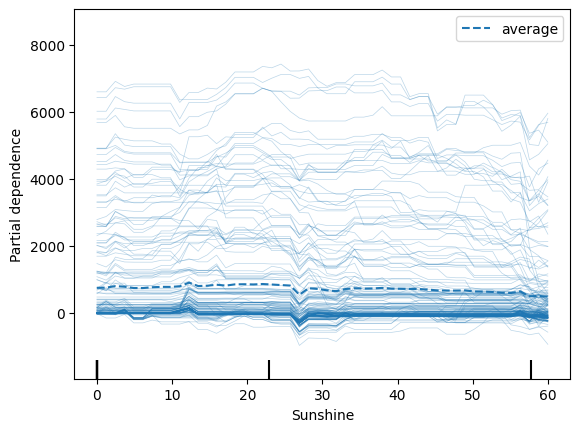

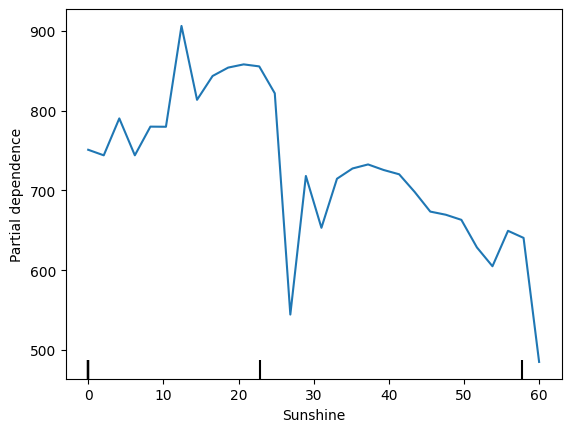

In [ ]:
from sklearn.inspection import PartialDependenceDisplay


# ---  Una variable: windspeed_100m  ---
PartialDependenceDisplay.from_estimator(
    lgbm_model,
    X_train,                       # mismo pre-procesado que el modelo
    features=['Sunshine'],
    kind='both',                   # 'average' (PD) + 'individual' (ICE)
    subsample=200,                 # cuántas ICE pintar
    grid_resolution=50,            # puntos del eje x
    random_state=0
)

# ---  Interacción 2-D entre windspeed_100m y temperature_2m  ---
PartialDependenceDisplay.from_estimator(
    lgbm_model,
    X_train,
    features=[('Sunshine')],
    kind='average',                # superficie PD media
    grid_resolution=30
)


In [53]:
from sklearn.neighbors import NearestNeighbors

exp = dx.Explainer(
        model       = lgbm_model,
        data        = X_train,          # exactly what the model saw
        y           = y_train,
        label       = "LightGBM",
        model_class = "regression"
)

# ───────────────────────────────────────────────
# 2.  Choose one record to inspect (row_id) …
#     … and find its 15 nearest neighbours on the 4 features
# ───────────────────────────────────────────────
row_id   = 10                          # any index you want to analyse
target_x = X_val.iloc[row_id]

similar_feat = ['WindSpeed', 'Sunshine',
                'Radiation', 'RelativeAirHumidity']

knn = NearestNeighbors(n_neighbors=15).fit(X_train[similar_feat])
idx_neigh  = knn.kneighbors(target_x[similar_feat]
                            .values.reshape(1, -1),
                            return_distance=False)[0]
neigh_data = X_train.iloc[idx_neigh]   # DataFrame with 15 most-similar rows

# ───────────────────────────────────────────────
# 3.  Ceteris-paribus (ICE) profiles for those neighbours
#     + cohort-mean (local PD) on the same plot
# ───────────────────────────────────────────────
cp = exp.predict_profile(
        neigh_data,
        variables = ['RelativeAirHumidity', 'Sunshine']        # pick any of the 4
)

# 1.  ICE individuales
ax = cp.plot(color="Radiation")             # sin argumentos extra

# # 2.  Línea PD de la misma cohorte
# mp_local = exp.model_profile(
#     data      = neigh_data,
#     variables = ['RelativeAirHumidity', 'Sunshine'],
#     type      = 'partial'
# )
# mp_local.plot(ax=ax, color="black", linewidth=3)   # añade media en negro          # color por Radiation



c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



Preparation of a new explainer is initiated

  -> data              : 28012 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 28012 values
  -> model_class       : regression
  -> label             : LightGBM
  -> predict function  : <function yhat_default at 0x000001CA6FFDCF40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -9.13e+02, mean = 6.81e+02, max = 7.72e+03
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -4.25e+03, mean = 3.94e-08, max = 5.03e+03
  -> model_info        : package lightgbm

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00, 154.27it/s]


In [40]:

exp = dx.Explainer(
    model=lgbm_model,
    data=X_train,
    y=y_train,
    label="LightGBM",
    model_class="regression",
)

######################################################################
# 2.  Pick one validation record and its 15 nearest neighbours
######################################################################
row_id = 10                          # any record you want
target_x = X_val.iloc[row_id]

knn = NearestNeighbors(n_neighbors=15).fit(X_train[selected_features])
idx_neigh = knn.kneighbors(
    target_x[selected_features].values.reshape(1, -1),
    return_distance=False
)[0]
neigh_data = X_train.iloc[idx_neigh]

######################################################################
# 3.  ICE curves (ceteris-paribus) for the neighbours
######################################################################
cp = exp.predict_profile(
    neigh_data,
    variables=["WindSpeed", "Sunshine"]      # X-axes we want
)

######################################################################
# 4.  Local Partial Dependence (mean of the 15 ICE curves)
#     – build a tiny “neighbour” explainer and call model_profile
######################################################################
exp_neigh = dx.Explainer(
    model=lgbm_model,
    data=neigh_data,
    y=lgbm_model.predict(neigh_data),        # dummy target
    label="LightGBM (15-neigh)",
    model_class="regression",
)

mp_local = exp_neigh.model_profile(
    variables=["WindSpeed", "Sunshine"],
    type="partial",
)

######################################################################
# 5.  Plot BOTH: (i) ICE coloured by Radiation, (ii) thick black PD
#     The Python API does not offer a universal `dx.plot`, so we:
#       • let cp.plot() draw first,
#       • overlay the PD mean with matplotlib using mp_local.result.
######################################################################
# 5-a  Draw ICE curves (each neighbour, coloured by Radiation)
cp.plot(color="Radiation", size=2)           # returns nothing, but draws

# 5-b  Overlay the black PD curve by hand
pd_df = mp_local.result                      # tidy DataFrame

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names



Preparation of a new explainer is initiated

  -> data              : 28012 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 28012 values
  -> model_class       : regression
  -> label             : LightGBM
  -> predict function  : <function yhat_default at 0x000001CA6FFDCF40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -9.13e+02, mean = 6.81e+02, max = 7.72e+03
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -4.25e+03, mean = 3.94e-08, max = 5.03e+03
  -> model_info        : package lightgbm

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00, 94.97it/s]


Preparation of a new explainer is initiated

  -> data              : 15 rows 5 cols
  -> target variable   : 15 values
  -> model_class       : regression
  -> label             : LightGBM (15-neigh)
  -> predict function  : <function yhat_default at 0x000001CA6FFDCF40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.515, mean = 1.54, max = 3.92
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = 0.0, mean = 0.0, max = 0.0
  -> model_info        : package lightgbm

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00, 143.75it/s]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_8076\86409281.py:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



KeyError: 'variable_value'

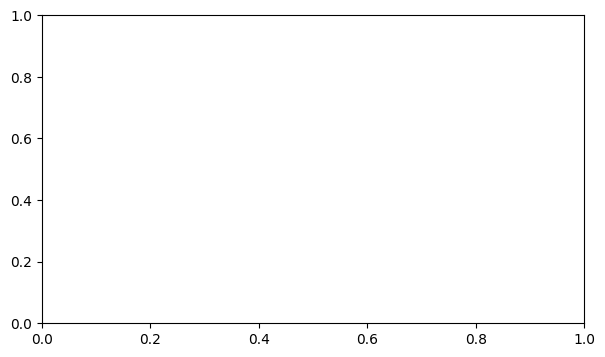

In [46]:
####################################################################
# 0.  ICE y PD local ya calculados: cp, mp_local
####################################################################
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# escala de color por producción real
sys_prod = y_train.loc[neigh_data.index]
norm = plt.Normalize(sys_prod.min(), sys_prod.max())
cmap = cm.get_cmap("viridis")

fig, ax = plt.subplots(figsize=(7, 4))

# --- 1.  ICE individuales coloreadas ------------------------------
ice_df = cp.result
for obs_id, df_obs in ice_df.groupby("_ids_"):
    colour = cmap(norm(sys_prod.loc[obs_id]))
    # solo WindSpeed; haz otro bucle si quieres Sunshine
    sub = df_obs[df_obs["_vname_"] == "WindSpeed"]
    ax.plot(sub["variable_value"], sub["_yhat_"],
            color=colour, linewidth=1)

# barra de color
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("SystemProduction (real)")

# --- 2.  Línea negra gruesa = PD local ----------------------------
pd_df = mp_local.result
pd_ws  = pd_df[pd_df["_vname_"] == "WindSpeed"]
ax.plot(pd_ws["variable_value"], pd_ws["_yhat_"],
        color="black", linewidth=3, label="PD mean")

ax.set_xlabel("WindSpeed")
ax.set_ylabel("Predicted SystemProduction")
ax.set_title("ICE coloured by SystemProduction\n(+ local PD mean)")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import shap

# Explicador
explainer = shap.Explainer(lgbm_model, X_train, additive=False)
shap_values = explainer(X_val)

# Explicación de una predicción individual (ej. la número 5)
shap.plots.waterfall(shap_values[25])  # Cambia el índice según necesites


ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 3577.449956, while the model output was 3264.461360. If this difference is acceptable you can set check_additivity=False to disable this check.

Par-par: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


Top-10 interacciones según H-stat:
 Sunshine     RelativeAirHumidity    1.072098
AirPressure  RelativeAirHumidity    1.026259
WindSpeed    RelativeAirHumidity    1.019175
             AirPressure            0.984443
Sunshine     AirPressure            0.889729
WindSpeed    Sunshine               0.801320
AirPressure  Radiation              0.390640
WindSpeed    Radiation              0.386957
Radiation    RelativeAirHumidity    0.334982
Sunshine     Radiation              0.315593
dtype: float64


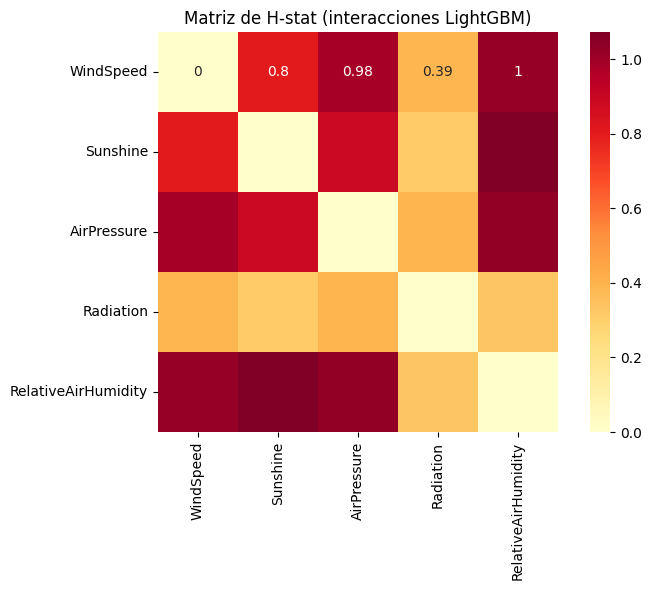

In [18]:
# Overall H-stat: This gives the percentage of the features effect on the predictions that come from the interactions with all other features.
# ------------------------------------------------------------
# 1. Imports y función para el H-stat emparejado (versión índices)
# ------------------------------------------------------------
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.inspection import partial_dependence
from tqdm import tqdm

def pairwise_h_stat(model, X, features=None, grid=20, sample=5000, verbose=True):
    """
    Friedman & Popescu Pairwise H-statistic usando índices de columna.
    """
    if features is None:
        features = X.columns.tolist()

    # Mapeo nombre → índice
    idx_map = {name: i for i, name in enumerate(X.columns)}
    feat_idx = [idx_map[f] for f in features]

    # Muestreo opcional para acelerar
    X_int = X.sample(sample, random_state=0) if sample and len(X) > sample else X

    # PDP univariante (por índice)
    pd_uni = {}
    for fi, fname in zip(feat_idx, features):
        res = partial_dependence(model, X_int, [fi],
                                 grid_resolution=grid, kind="average")
        pd_uni[fname] = res["average"][0].ravel()   # (g,)

    # Matriz H vacía
    h_mat = pd.DataFrame(np.zeros((len(features), len(features))),
                         index=features, columns=features)

    # Cálculo par-par (índices)
    iterator = combinations(range(len(features)), 2)
    if verbose:
        iterator = tqdm(list(iterator), desc="Par-par")

    for i, j in iterator:
        f1, f2 = features[i], features[j]
        idx1, idx2 = feat_idx[i], feat_idx[j]

        res   = partial_dependence(model, X_int, [(idx1, idx2)],
                                   grid_resolution=grid, kind="average")
        pd_ij = res["average"][0]                  # (g1, g2)

        num = np.sum((pd_ij
                      - pd_uni[f1][:, None]
                      - pd_uni[f2][None, :])**2)
        den = np.sum(pd_ij**2)
        h   = np.sqrt(num / den) if den > 0 else 0.0

        h_mat.iloc[i, j] = h_mat.iloc[j, i] = h

    return h_mat

# ------------------------------------------------------------
# 2. Alineamos las columnas EXACTAS del LightGBM
# ------------------------------------------------------------
cols_model = lgbm_model.feature_name_          # nombres usados al entrenar
X_model    = X_full[cols_model]                # mismo orden y nº de columnas

# ------------------------------------------------------------
# 3. Calculamos H-matrix, ranking y heat-map
# ------------------------------------------------------------
h_matrix = pairwise_h_stat(lgbm_model, X_model,
                           features=cols_model,
                           grid=20, sample=5000)

# Top-10 interacciones
top10 = (h_matrix.where(np.triu(np.ones(h_matrix.shape), k=1).astype(bool))
                   .stack()
                   .sort_values(ascending=False)
                   .head(10))
print("Top-10 interacciones según H-stat:\n", top10)

# Heat-map opcional
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(h_matrix, annot=True, cmap="YlOrRd", square=True)
plt.title("Matriz de H-stat (interacciones LightGBM)")
plt.tight_layout(); plt.show()




In [17]:
# Hacemos H'STAT con Artemis
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod, GreenwellMethod
grenwell_method = GreenwellMethod()

h_stat = FriedmanHStatisticMethod()
h_stat.fit(lgbm_model, X_val, show_progress=True, pd_calculator=grenwell_method.pd_calculator)   # aquí sí necesita los datos de validación

h_stat.plot()
# Gráfica resumen (heat-map + barras + grafo)
h_stat.plot(
    title="Friedman H-Statistic – LightGBM"
)
h_stat.ova
h_stat.plot('bar_chart_ova')

#H-statistics also has a modification - unnormalized version. It potentially reduce the number of spurious interactions indicated by the method.

h_stat_unnormalized = FriedmanHStatisticMethod(normalized=False)
h_stat_unnormalized.fit(lgbm_model, X_val, pd_calculator=grenwell_method.pd_calculator)
h_stat_unnormalized.plot()


Calculating one vs one interactions:  10%|█         | 1/10 [01:11<10:41, 71.27s/it]


KeyboardInterrupt: 

100%|██████████| 100/100 [00:07<00:00, 14.21it/s]
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



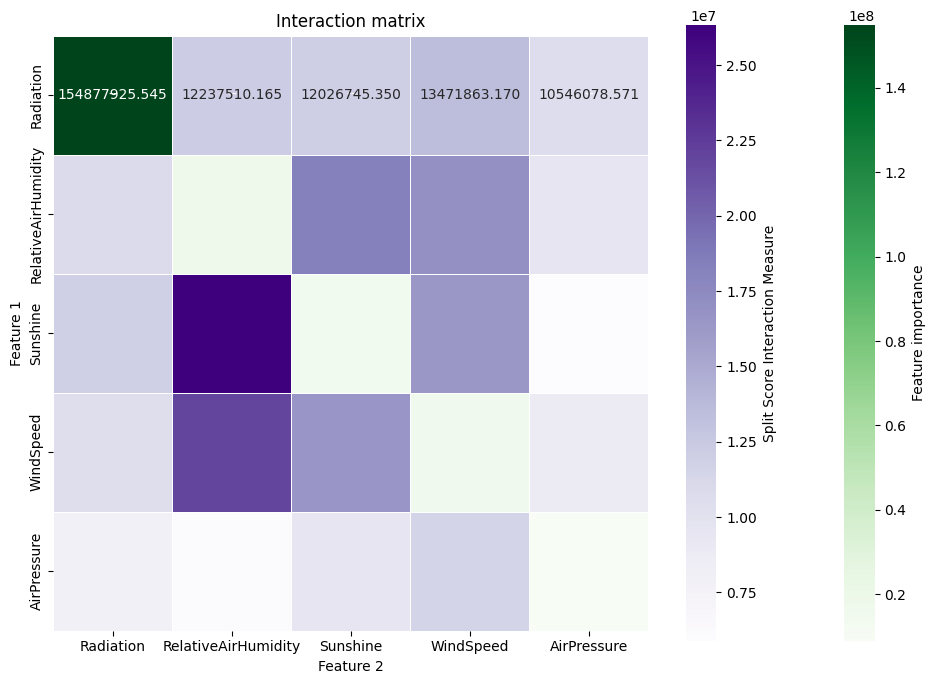

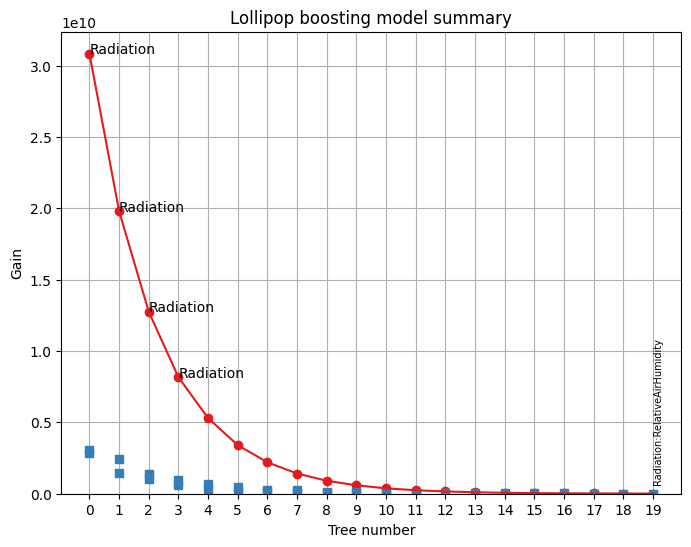

In [16]:
# This is a method proposed by Karbowiak and Biecek. It is suitable for gradient-boosted trees models and used their structure for extracting interactions. Namely, it compares split scores (gain, cover) of consecutive nodes in trees.
from artemis.interactions_methods.model_specific import SplitScoreMethod

split_score = SplitScoreMethod()
split_score.fit(lgbm_model, show_progress=True, interaction_selected_metric = "mean_gain")

split_score.plot(figsize=(12, 10))
split_score.plot('lollipop', label_threshold = 0.2 )